In [23]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Multi_Task_Full_Rank_Model, 
    train_multi_task, 
    model_eval
)

seed = 666
set_seed(seed)

In [24]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [25]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [29]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="wheel_speed",
    data_type="all_ks",
    n_t_bins = 30
)

/home/berk/anaconda3/envs/decoding/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)


brainbox.behavior.wheel.velocity has been deprecated. Use velocity_filtered instead.


File "/home/berk/anaconda3/envs/decoding/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
File "/home/berk/anaconda3/envs/decoding/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
File "/home/berk/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
File "/home/berk/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
File "/home/berk/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
    self.io_loop.start()
File "/home/berk/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
File "/home/berk/anaconda3/envs/decoding/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
File "/home/berk/anaconda3/envs/decoding/lib/python3.10/asyncio/base_events.py", line 19

AssertionError: invalid behavior type; expected one of ['choice', 'prior', 'contrast', 'reward', 'motion_energy', 'wheel_velocity', 'wheel_speed', 'pupil_diameter', 'paw_speed'].

In [ ]:
# # print(X_dict)
# print(len(Y_dict))
# # loop through Y_dict and print the length of each key
# for key in X_dict:
#     print(len(X_dict[key]))
#     print(X_dict[key].shape)
#     print(X_dict[key])

#     # Save the np array to a file
#     np.save('X_brain.npy', X_dict[key])
# for key in Y_dict:
#     print(len(Y_dict[key]))
#     print(Y_dict[key].shape)

#     # Save the np array to a file
#     np.save('Y_brain.npy', Y_dict[key])

In [ ]:
# an example of model training and eval

start_time = time.time()

example_pid = pids[0]

d = 0 # half window size
n_epochs = 7000

# prepare data
n_units = []
train_X_lst, train_Y_lst, test_X_lst, test_Y_lst = [], [], [], []
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    print(X.shape, Y.shape)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)
    train_X_lst.append(train_X)
    train_Y_lst.append(train_Y)
    test_X_lst.append(test_X)
    test_Y_lst.append(test_Y)
    n_units.append(C)

    
multi_task_frm = Multi_Task_Full_Rank_Model(
    n_tasks=len(pids),
    n_units=n_units, 
    n_t_bins=T, 
    half_window_size=d,
    soft_loss_penalty=1e-1
)

# training
multi_task_frm, train_losses = train_multi_task(
    model=multi_task_frm,
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=0,
    n_epochs=n_epochs,
)

# eval
test_Beta, test_metrics, _ = model_eval(
    multi_task_frm, 
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    behavior="choice"
)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

ValueError: could not broadcast input array from shape (30,) into shape (1,)

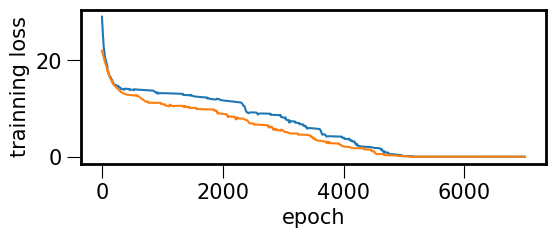

In [10]:
plt.figure(figsize=(6,2))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("trainning loss")
plt.show()

In [11]:
R = 2 # rank
d = 0 # half window size
n_epochs = 7000
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

n_units = []
train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    n_units.append(C)
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X_dict.update({pid: [X[train] for train, _ in skf.split(X, Y)]})
    test_X_dict.update({pid: [X[test] for _, test in skf.split(X, Y)]})
    train_Y_dict.update({pid: [Y[train] for train, _ in skf.split(X, Y)]})
    test_Y_dict.update({pid: [Y[test] for _, test in skf.split(X, Y)]})

In [13]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

Beta_per_fold, metrics_per_fold = [], []
for fold_idx in range(n_folds):
    
    print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
    train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
    test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
    train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
    test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]
    
    multi_task_frm = Multi_Task_Full_Rank_Model(
        n_tasks=len(pids),
        n_units=n_units, 
        n_t_bins=T, 
        half_window_size=d,
        soft_loss_penalty=1e-1
    )

    # training
    multi_task_frm, train_losses = train_multi_task(
        model=multi_task_frm,
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        loss_function=torch.nn.BCELoss(),
        learning_rate=1e-3,
        weight_decay=0,
        n_epochs=n_epochs,
    )

    # eva
    test_Beta, test_metrics, _ = model_eval(
        multi_task_frm, 
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        behavior="choice"
    )
    Beta_per_fold.append(test_Beta)
    metrics_per_fold.append(test_metrics)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start training fold 1 on 2 sessions ..
Epoch [700/7000], Loss: 19.292680997514527
Epoch [1400/7000], Loss: 15.128446879105075
Epoch [2100/7000], Loss: 10.468517552390255
Epoch [2800/7000], Loss: 7.288668878206379
Epoch [3500/7000], Loss: 5.0793213857705615
Epoch [4200/7000], Loss: 1.1598249746493603
Epoch [4900/7000], Loss: 0.27440717849434165
Epoch [5600/7000], Loss: 0.06733687711798746
Epoch [6300/7000], Loss: 0.04362275007644546
Epoch [7000/7000], Loss: 0.04282769423954831
task 0 train accuracy: 1.000 auc: 1.000
task 0 test accuracy: 0.851 auc: 0.941
task 1 train accuracy: 1.000 auc: 1.000
task 1 test accuracy: 0.871 auc: 0.935
start training fold 2 on 2 sessions ..
Epoch [700/7000], Loss: 17.917853038072884
Epoch [1400/7000], Loss: 14.04307648378828
Epoch [2100/7000], Loss: 11.162536939154666
Epoch [2800/7000], Loss: 7.358728263319911
Epoch [3500/7000], Loss: 5.319976679143857
Epoch [4200/7000], Loss: 1.780256596663759
Epoch [4900/7000], Loss: 0.4212728850375542
Epoch [5600/7000], 

In [14]:
Betas, metrics_dict = {}, {}
for pid_idx, pid in enumerate(pids):
    metrics_dict.update({pid: np.mean(metrics_per_fold, 0)[pid_idx]})
    Betas.update({pid: [Beta_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)]})

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["accuracy", "auc"]
metrics_df

,accuracy,auc
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.828286,0.908862
febb430e-2d50-4f83-87a0-b5ffbb9a4943,0.822857,0.890637


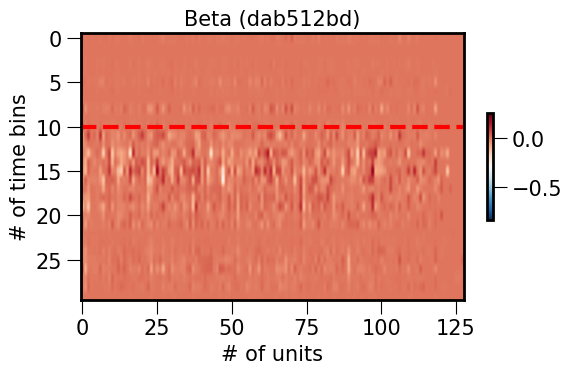

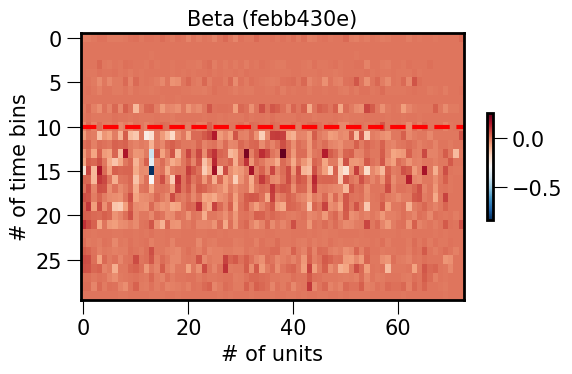

In [15]:
Betas_plot = []
for pid in pids:
    # average Beta across trials
    Betas_plot.append(np.array(Betas[pid]).mean(0).squeeze())
beta_min, beta_max = np.min(np.concatenate(Betas_plot)), np.max(np.concatenate(Betas_plot))
    
for pid_idx, pid in enumerate(pids):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    heatmap = ax.imshow(Betas_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=beta_min, vmax=beta_max)
    ax.axhline(y=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap, ax=ax, shrink=0.4)
    ax.set_ylabel("# of time bins")
    ax.set_xlabel("# of units")
    ax.set_title(f"Beta ({pid[:8]})")
    plt.tight_layout()